In [163]:
import sys
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from flow import Node, CreditFlow, Graph, get_source_nodes, topo_sort, flatten_graph, eval_graph, boundary_graph, single_source_graph, viz_graph, save_graph, hcluster_graph
from flow import ParallelCreditFlow, GraphExplainer, translator
from flow import group_nodes, build_feature_graph
from flow import CausalLinks, create_xgboost_f

if '../shap' not in sys.path:
    sys.path = ['../shap'] + sys.path
    import shap
    
import tqdm
from numba import jit
import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
from graphviz import Digraph, Source
from pygraphviz import AGraph
import numpy as np
import matplotlib.image as mpimg
from IPython.display import Image
import matplotlib.pyplot as plt
import copy
import seaborn as sns
import scipy as sp
import scipy.cluster
import matplotlib.pyplot as pl

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
X,y = shap.datasets.nhanesi()
X_display,y_display = shap.datasets.nhanesi(display=True) # human readable feature values
# remove the first column: unnamed: 0
X = X.iloc[:, 1:]
X_display = X_display.iloc[:, 1:]

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

print(X.shape, X_display.shape)
X.head()

(9932, 18) (9932, 18)


,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
0,35.0,92.0,126.0,2.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2.0,142.0,323.0,41.8,5.8,31.109434,50.0
1,71.0,78.0,210.0,2.0,77.7,37.0,4.0,298.0,89.0,1.38,6.4,2.0,156.0,331.0,26.9,5.3,32.362572,78.0
2,74.0,86.0,999.0,2.0,77.7,31.0,3.8,222.0,115.0,1.37,7.4,2.0,170.0,299.0,38.5,8.1,25.388497,84.0
3,64.0,92.0,385.0,1.0,77.7,30.0,4.3,265.0,94.0,1.97,7.3,2.0,172.0,349.0,26.9,6.7,26.446610,80.0
4,32.0,70.0,183.0,2.0,77.7,18.0,5.0,203.0,192.0,1.35,7.3,1.0,128.0,386.0,49.7,8.1,20.354684,58.0


In [4]:
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
model_train = xgboost.train(params, xgb_train, 1000, evals = [(xgb_test, "test")], verbose_eval=1000)

# workaround from https://github.com/slundberg/shap/issues/1215
mybooster = model_train

model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

[0]	test-cox-nloglik:7.26934
[999]	test-cox-nloglik:6.55579


In [5]:
# train final model on the full data set
params = {
    "eta": 0.002,
    "max_depth": 3, 
    "objective": "survival:cox",
    "subsample": 0.5
}
model = xgboost.train(params, xgb_full, 1000, evals = [(xgb_full, "test")], verbose_eval=1000)

# workaround from https://github.com/slundberg/shap/issues/1215
mybooster = model

model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

[0]	test-cox-nloglik:8.88081
[999]	test-cox-nloglik:8.16748


In [6]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

# see how well we can order people by survival
c_statistic_harrell(model_train.predict(xgb_test, ntree_limit=5000), y_test)

0.8289463410825477

# flat graph

In [164]:
causal_links = CausalLinks()
categorical_feature_names = ['Race', 'Sex']
display_translator = translator(X.columns, X, X_display)
target_name = 'predicted hazard'
feature_names = list(X.columns)

# build causal links
causal_links.add_causes_effects(feature_names, target_name, create_xgboost_f(feature_names, model)) # the target
graph = build_feature_graph(X.fillna(X.mean()), causal_links, categorical_feature_names, display_translator, target_name)

0it [00:00, ?it/s]


In [165]:
nsamples = 100
explainer = GraphExplainer(graph, X, nruns=100) 
cf = explainer.shap_values(X[:nsamples])

bruteforce sampling: 100%|██████████| 100/100 [00:05<00:00, 17.65it/s]


# TODO: change to log space

In [225]:
bg = shap.utils.sample(X, 100)
explainer = shap.Explainer(lambda x: model.predict(xgboost.DMatrix(x), validate_features=False, output_margin=True), bg)
shap_values = explainer(X[:100])

Permutation explainer: 101it [00:38,  2.66it/s]                         


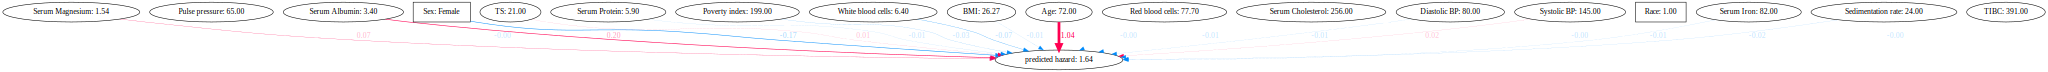

In [173]:
sample_ind = 60
cf.draw(sample_ind)

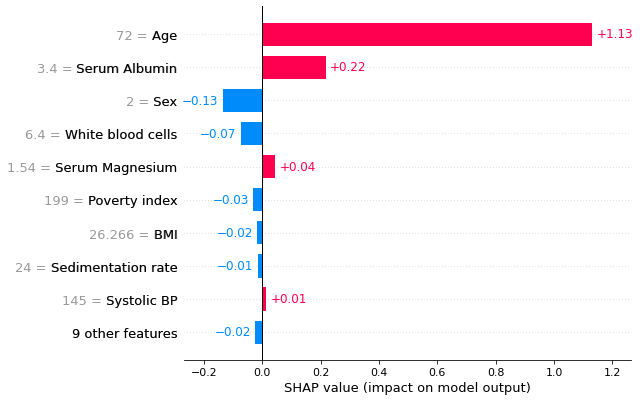

In [174]:
shap.plots.bar(shap_values[sample_ind])

In [175]:
print(X.iloc[sample_ind])
print('target:', model.predict(xgboost.DMatrix(X.iloc[sample_ind:sample_ind+1])))

Age                    72.000000
Diastolic BP           80.000000
Poverty index         199.000000
Race                    1.000000
Red blood cells        77.700000
Sedimentation rate     24.000000
Serum Albumin           3.400000
Serum Cholesterol     256.000000
Serum Iron             82.000000
Serum Magnesium         1.540000
Serum Protein           5.900000
Sex                     2.000000
Systolic BP           145.000000
TIBC                  391.000000
TS                     21.000000
White blood cells       6.400000
BMI                    26.265815
Pulse pressure         65.000000
Name: 60, dtype: float64
target: [1.6427237]


# cluster graph

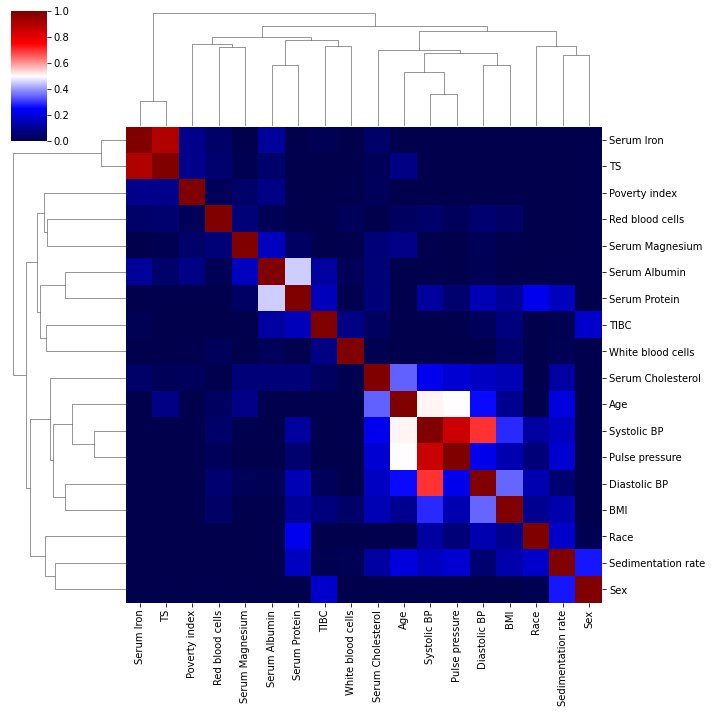

In [14]:
sns.clustermap(X.corr(), cmap='seismic', vmax=1, vmin=0)

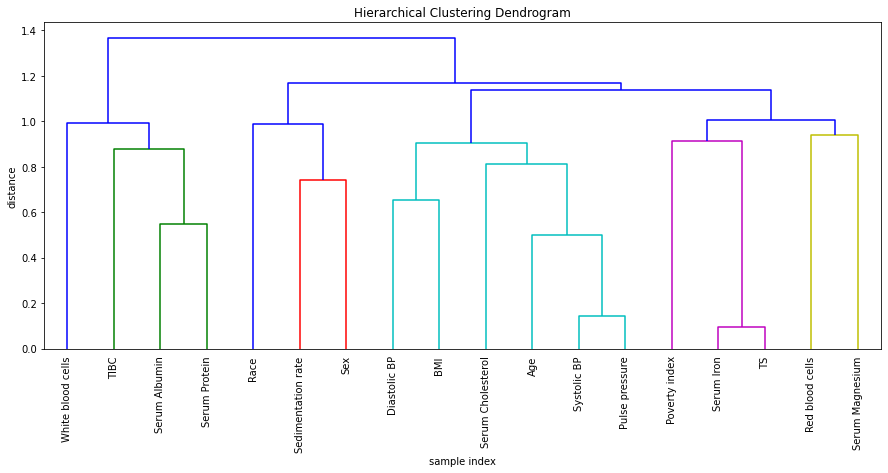

In [15]:
D = sp.spatial.distance.pdist(X.fillna(X.mean()).T, metric="correlation")
cluster_matrix = sp.cluster.hierarchy.complete(D)

# plot the clustering
pl.figure(figsize=(15, 6))
pl.title('Hierarchical Clustering Dendrogram')
pl.xlabel('sample index')
pl.ylabel('distance')
sp.cluster.hierarchy.dendrogram(
    cluster_matrix,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    labels=X.columns
)
pl.show()

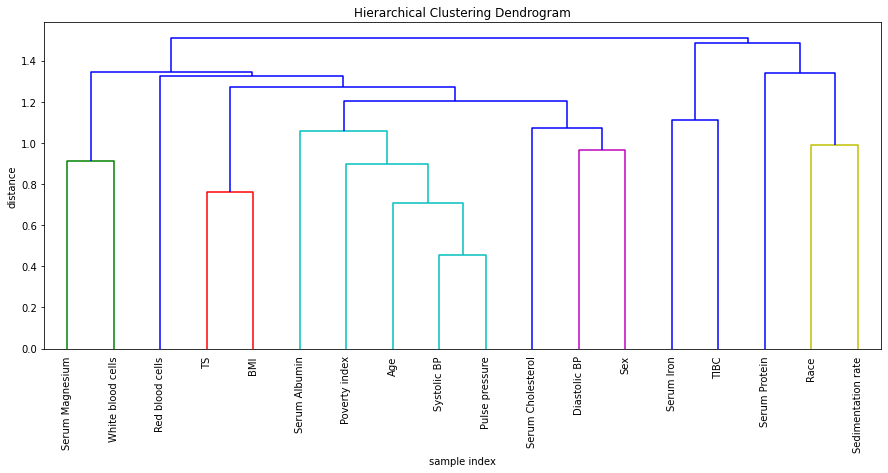

In [16]:
cluster_matrix_shap = shap.utils.hclust(X, y)

# plot the clustering
pl.figure(figsize=(15, 6))
pl.title('Hierarchical Clustering Dendrogram')
pl.xlabel('sample index')
pl.ylabel('distance')
sp.cluster.hierarchy.dendrogram(
    cluster_matrix_shap,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    labels=X.columns
)
pl.show()

In [19]:
E = GraphExplainer(graph, X)
E.prepare_graph(X[:nsamples])
cf_h = CreditFlow(hcluster_graph(E.graph, list(X.columns), cluster_matrix), nruns=-1)
cf_h.run(method='divide_and_conquer')

divide_and_conquer at level 0: 2it [00:08,  4.48s/it]


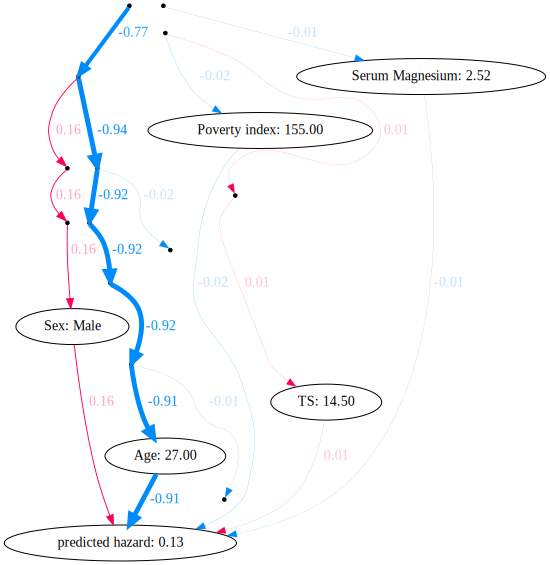

In [21]:
cf_h.draw(20, max_display=20)

# incorporate causal relationship

In [34]:
X.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
0,35.0,92.0,126.0,2.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2.0,142.0,323.0,41.8,5.8,31.109434,50.0
1,71.0,78.0,210.0,2.0,77.7,37.0,4.0,298.0,89.0,1.38,6.4,2.0,156.0,331.0,26.9,5.3,32.362572,78.0
2,74.0,86.0,999.0,2.0,77.7,31.0,3.8,222.0,115.0,1.37,7.4,2.0,170.0,299.0,38.5,8.1,25.388497,84.0
3,64.0,92.0,385.0,1.0,77.7,30.0,4.3,265.0,94.0,1.97,7.3,2.0,172.0,349.0,26.9,6.7,26.446610,80.0
4,32.0,70.0,183.0,2.0,77.7,18.0,5.0,203.0,192.0,1.35,7.3,1.0,128.0,386.0,49.7,8.1,20.354684,58.0


In [205]:
causal_links = CausalLinks()
categorical_feature_names = ['Race', 'Sex']
display_translator = translator(X.columns, X, X_display)
target_name = 'predicted hazard'
feature_names = list(X.columns)

# build causal links
causal_links.add_causes_effects(feature_names, target_name, create_xgboost_f(feature_names, model)) # the target
A = ['Age', 'Sex', 'Poverty index', 'Race']
causal_links.add_causes_effects(A, list(set(feature_names) - set(A)))
A = ['Age', 'Sex', 'Race']
causal_links.add_causes_effects(A, 'Poverty index')

causal_graph = build_feature_graph(X.fillna(X.mean()), causal_links, categorical_feature_names, display_translator, target_name)

learning dependency for Pulse pressure:   0%|          | 0/15 [00:00<?, ?it/s]

[0]	test-rmse:53.88531
[100]	test-rmse:44.89068
[200]	test-rmse:37.68130
[300]	test-rmse:31.96442
[400]	test-rmse:27.49237
[499]	test-rmse:24.07019


learning dependency for BMI:   7%|▋         | 1/15 [00:00<00:09,  1.55it/s]           

[0]	test-rmse:25.68026
[100]	test-rmse:21.22700
[200]	test-rmse:17.61862
[300]	test-rmse:14.70853
[400]	test-rmse:12.38153
[499]	test-rmse:10.55001


learning dependency for Systolic BP:  13%|█▎        | 2/15 [00:01<00:08,  1.54it/s]

[0]	test-rmse:136.18751
[100]	test-rmse:112.07594
[200]	test-rmse:92.46082
[300]	test-rmse:76.55484
[400]	test-rmse:63.71541
[499]	test-rmse:53.49734


learning dependency for Red blood cells:  20%|██        | 3/15 [00:01<00:07,  1.53it/s]

[0]	test-rmse:56.62017
[100]	test-rmse:47.20332
[200]	test-rmse:39.64856
[300]	test-rmse:33.63278
[400]	test-rmse:28.88807
[499]	test-rmse:25.23218


learning dependency for Serum Protein:  27%|██▋       | 4/15 [00:02<00:07,  1.54it/s]  

[0]	test-rmse:6.61101
[100]	test-rmse:5.42027
[200]	test-rmse:4.44728
[300]	test-rmse:3.65282
[400]	test-rmse:3.00507
[499]	test-rmse:2.48216


learning dependency for Serum Cholesterol:  33%|███▎      | 5/15 [00:03<00:06,  1.59it/s]

[0]	test-rmse:226.94264
[100]	test-rmse:187.87550
[200]	test-rmse:156.24815
[300]	test-rmse:130.78793
[400]	test-rmse:110.44482
[499]	test-rmse:94.44800


learning dependency for White blood cells:  40%|████      | 6/15 [00:03<00:05,  1.57it/s]

[0]	test-rmse:7.24529
[100]	test-rmse:6.04540
[200]	test-rmse:5.08526
[300]	test-rmse:4.32187
[400]	test-rmse:3.72444
[499]	test-rmse:3.26567


learning dependency for Serum Iron:  47%|████▋     | 7/15 [00:06<00:08,  1.11s/it]       

[0]	test-rmse:105.80270
[100]	test-rmse:88.86579
[200]	test-rmse:75.45216
[300]	test-rmse:64.97790
[400]	test-rmse:56.92674
[499]	test-rmse:50.90213


learning dependency for TS:  53%|█████▎    | 8/15 [00:07<00:07,  1.07s/it]        

[0]	test-rmse:29.79472
[100]	test-rmse:25.10774
[200]	test-rmse:21.40968
[300]	test-rmse:18.53344
[400]	test-rmse:16.33232
[499]	test-rmse:14.69491


learning dependency for Serum Magnesium:  60%|██████    | 9/15 [00:07<00:05,  1.06it/s]

[0]	test-rmse:1.18907
[100]	test-rmse:0.97714
[200]	test-rmse:0.80443
[300]	test-rmse:0.66402
[400]	test-rmse:0.55023
[499]	test-rmse:0.45920


learning dependency for Poverty index:  67%|██████▋   | 10/15 [00:08<00:04,  1.15it/s]  

[0]	test-rmse:365.16959
[100]	test-rmse:325.23489
[200]	test-rmse:295.42532
[300]	test-rmse:273.60980
[400]	test-rmse:257.95938
[499]	test-rmse:247.04846


learning dependency for Sedimentation rate:  73%|███████▎  | 11/15 [00:08<00:03,  1.26it/s]

[0]	test-rmse:19.38453
[100]	test-rmse:16.95487
[200]	test-rmse:15.09857
[300]	test-rmse:13.70687
[400]	test-rmse:12.67748
[499]	test-rmse:11.94172


learning dependency for Diastolic BP:  80%|████████  | 12/15 [00:09<00:02,  1.28it/s]      

[0]	test-rmse:83.71988
[100]	test-rmse:68.93323
[200]	test-rmse:56.90493
[300]	test-rmse:47.15287
[400]	test-rmse:39.27799
[499]	test-rmse:33.00833


learning dependency for Serum Albumin:  87%|████████▋ | 13/15 [00:10<00:01,  1.35it/s]

[0]	test-rmse:3.87407
[100]	test-rmse:3.17810
[200]	test-rmse:2.60949
[300]	test-rmse:2.14547
[400]	test-rmse:1.76748
[499]	test-rmse:1.46278


learning dependency for TIBC:  93%|█████████▎| 14/15 [00:11<00:00,  1.24it/s]         

[0]	test-rmse:365.08758
[100]	test-rmse:300.40860
[200]	test-rmse:247.82375
[300]	test-rmse:205.21208
[400]	test-rmse:170.85916
[499]	test-rmse:143.55504


learning dependency for TIBC: 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


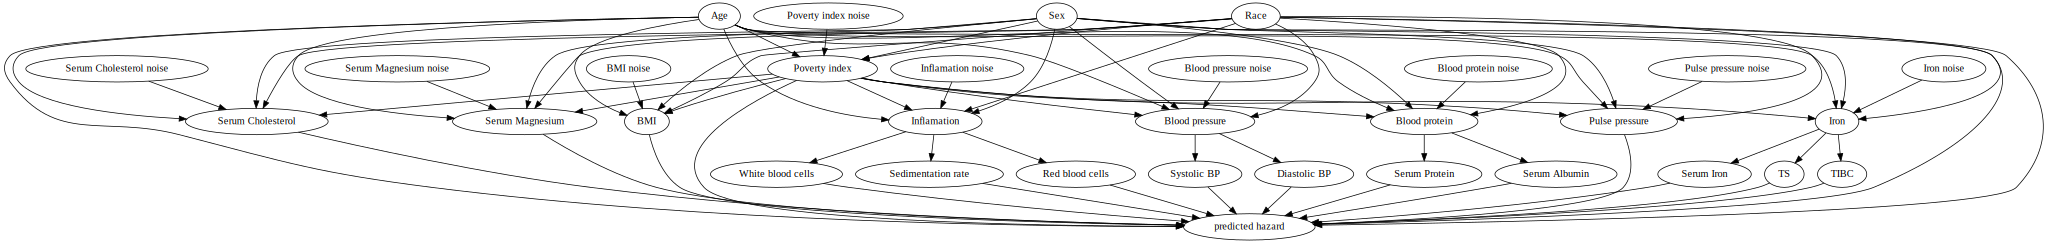

In [206]:
E = GraphExplainer(causal_graph, X)
E.prepare_graph(X) # add noise node
G = copy.deepcopy(E.graph)
G = group_nodes(G, [n for n in G if n.name in ['White blood cells', 'Sedimentation rate', 'Red blood cells']], 'Inflamation')
G = group_nodes(G, [n for n in G if n.name in ['Systolic BP', 'Diastolic BP']], 'Blood pressure')
G = group_nodes(G, [n for n in G if n.name in ['TS', 'TIBC', 'Serum Iron']], 'Iron')
G = group_nodes(G, [n for n in G if n.name in ['Serum Protein', 'Serum Albumin']], 'Blood protein')
G.draw()

In [207]:
cf_c = GraphExplainer(G, X, nruns=30).shap_values(X[:100], skip_prepare=True) # skip prepare b/c already prepared the noise and samplers

bruteforce sampling: 100%|██████████| 30/30 [04:41<00:00,  9.37s/it]


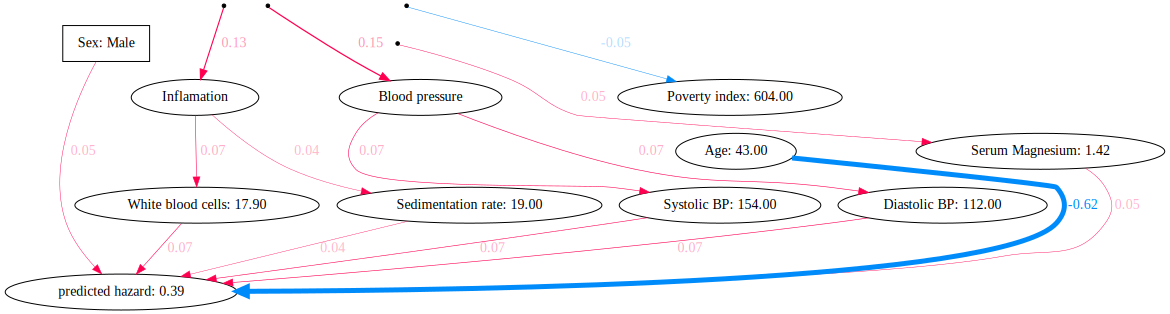

In [224]:
sample_ind = 66 # 66, 3, 22
cf_c.fold_noise = True
cf_c.draw(sample_ind, max_display=15)

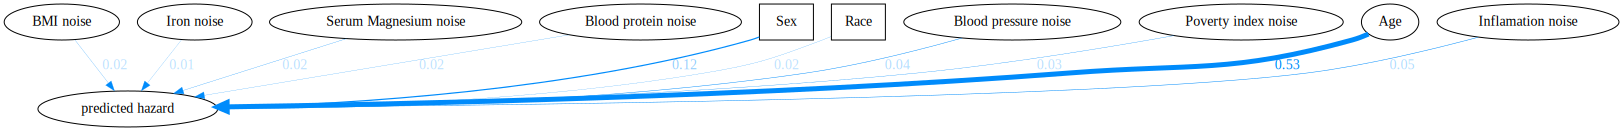

In [221]:
cf_c.fold_noise = False
cf_c.draw_asv(sample_ind, max_display=10)

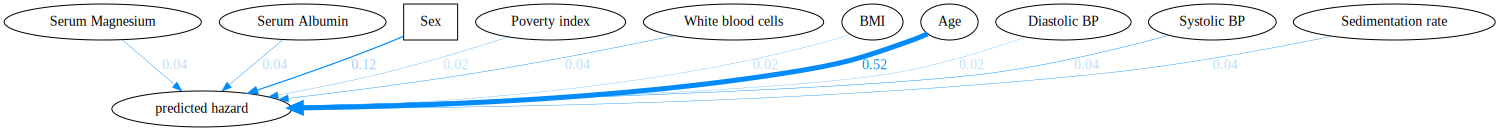

In [222]:
cf.draw(idx=sample_ind, max_display=10)

It seems like the model strongly depends on Age and Sex. Blood pressure and inflation also seems interesting. However, there is no interesting path found from observed variable to other observed variables.